In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm

## Import Dataset

In [6]:
filePath = "/content/FinancialMarketData - EWS.csv"
financial_market_data = pd.read_csv(filePath)

## EDA: Exploratory Data Analysis

In [5]:
financial_market_data.head()

,Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,0,1/11/2000,283.25,0.077,1388.0,157.26,100.56,105.86,1.646,25.77,...,116.464,230.527,123.762,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,0,1/18/2000,287.65,0.043,1405.0,165.01,101.86,105.47,1.638,28.85,...,117.267,231.377,123.762,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,0,1/25/2000,287.15,0.135,1368.0,167.24,102.41,106.04,1.650,28.28,...,117.995,232.390,123.762,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,0,2/1/2000,282.75,0.191,1311.0,166.85,104.92,107.85,1.611,28.22,...,120.510,231.942,122.328,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,1,2/8/2000,298.40,0.312,1277.0,165.43,104.22,109.30,1.611,28.02,...,118.791,237.812,122.328,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32


In [6]:
financial_market_data.shape

(1111, 44)

In [7]:
time_series = financial_market_data["Data"]
numeric_data = financial_market_data.loc[:, financial_market_data.columns != 'Data']

In [8]:
numeric_data.describe()

,Y,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,...,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000
mean,0.213321,987.463744,0.036153,2259.860486,245.247670,90.934982,106.605734,1.569661,60.708101,19.992169,...,232.109985,704.379545,259.052717,1606.997102,107.877138,784.846292,1903.216436,648.681377,693.156616,53.933159
std,0.409837,494.623740,0.349453,2017.811888,68.278066,11.379095,12.840754,0.212344,25.900813,8.642157,...,109.917628,309.951757,75.934451,698.481956,20.795973,200.076443,986.468254,299.096020,405.527014,24.738356
min,0.000000,256.680000,-0.974000,291.000000,106.293000,71.329000,75.940000,1.172000,10.010000,9.430000,...,80.797000,230.527000,121.331000,663.690000,56.300000,431.710000,280.500000,151.250000,112.600000,13.460000
25%,0.000000,433.740000,-0.191000,990.000000,184.705550,81.240500,101.565000,1.418000,39.625000,13.640000,...,131.025000,434.661000,205.315500,1103.925000,90.605000,601.615000,1042.645000,463.195000,278.385000,28.565000
50%,0.000000,1137.800000,0.035000,1518.000000,234.560000,89.716000,108.720000,1.562000,57.400000,17.980000,...,213.205000,714.807000,264.770000,1324.430000,111.320000,786.830000,1860.960000,612.930000,691.530000,58.740000
75%,0.000000,1324.825000,0.260500,2685.500000,301.539500,97.404000,116.220000,1.677500,79.640000,23.625000,...,342.884500,939.824500,320.753000,1992.445000,126.470000,965.875000,2533.770000,793.620000,1014.750000,68.460000
max,1.000000,2006.910000,0.991000,11793.000000,467.570000,119.820000,134.630000,2.085000,140.970000,75.910000,...,431.552800,1286.353000,398.706500,4043.690000,146.390000,1210.580000,4721.360000,1617.640000,1730.510000,129.200000


In [9]:
class_0 = numeric_data[numeric_data['Y'] == 0]
class_1 = numeric_data[numeric_data['Y'] == 1]

In [10]:
class_0.shape, class_1.shape

((874, 43), (237, 43))

In [11]:
correlation_matrix = numeric_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

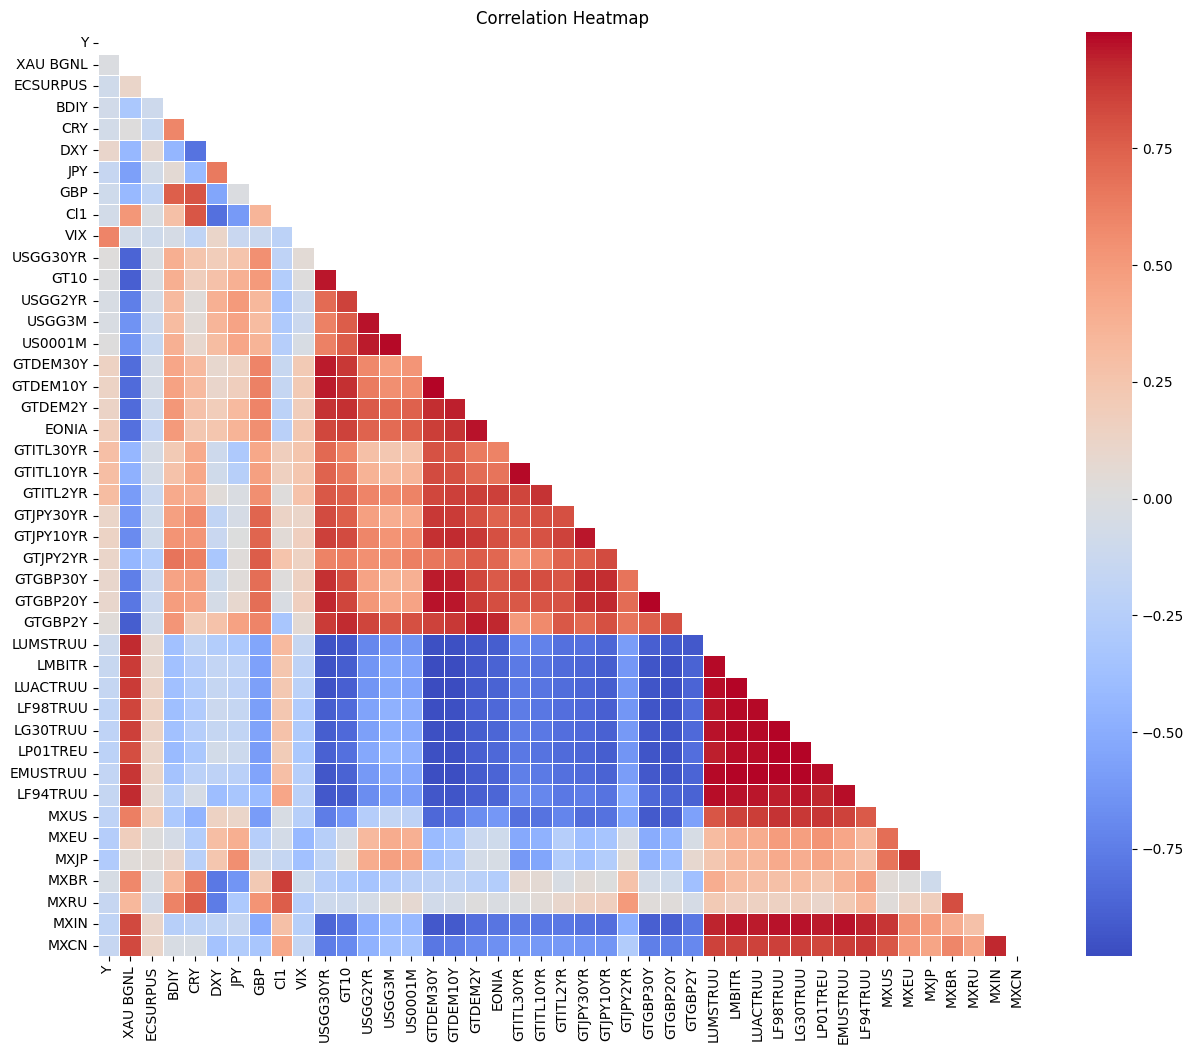

In [12]:
plt.figure(figsize=(15, 12))  # Adjust the figure size for readability
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5, mask=mask)
plt.title("Correlation Heatmap")
plt.show()

In [13]:
correlations = numeric_data.corr()["Y"].sort_values(ascending = True)
correlations

,Y
MXJP,-0.279399
MXEU,-0.253877
LP01TREU,-0.209774
LG30TRUU,-0.197232
MXUS,-0.193928
LF98TRUU,-0.189661
MXIN,-0.188942
EMUSTRUU,-0.169475
LF94TRUU,-0.156550
LUACTRUU,-0.153544


## Feature Selection

*   As a general rule of thumb, features with absolute value >=0.3 are to be considered for predictions.
*   So here, VIX [0.6] is the important feature with GTITL2YR [0.3], MXJP [-0.28], MXEU [-0.25] can also be accounted for.
*   We skip GTITL10YR [0.297], GTITL30YR [0.295] due to their high collinearity with GTITL2YR.



In [14]:
features_data = numeric_data[["Y", "VIX"]]

In [15]:
features_data

,Y,VIX,GTITL2YR
0,0,22.50,4.495
1,0,21.50,4.535
2,0,23.02,4.511
3,0,23.45,4.540
4,1,21.25,4.638
...,...,...,...
1106,0,20.30,-0.415
1107,0,19.61,-0.382
1108,0,18.12,-0.377
1109,0,16.65,-0.363


## Time-Series Models

### ARIMA

Checking for stationarity

In [25]:
arima_ts = financial_market_data["VIX"]

In [26]:
arima_ts.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1111 entries, 0 to 1110
Series name: VIX
Non-Null Count  Dtype  
--------------  -----  
1111 non-null   float64
dtypes: float64(1)
memory usage: 8.8 KB


<Axes: >

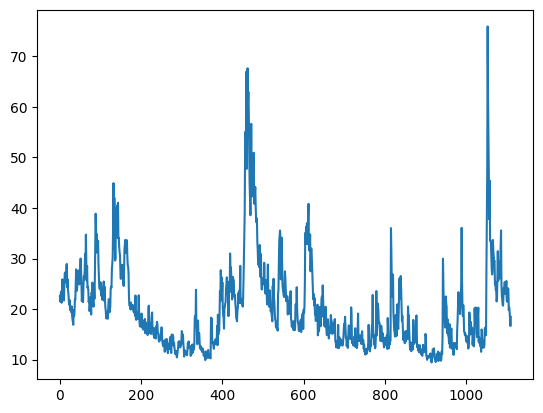

In [27]:
arima_ts.plot()

<Axes: >

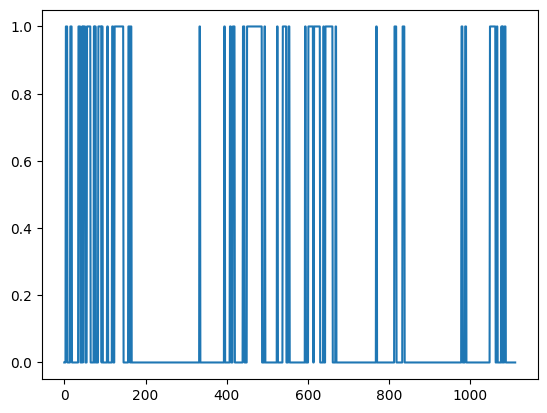

In [28]:
financial_market_data["Y"].plot()

In [29]:
msk = (arima_ts.index < len(arima_ts)-30)
arima_ts_train = arima_ts[msk].copy()
arima_ts_test = arima_ts[~msk].copy()

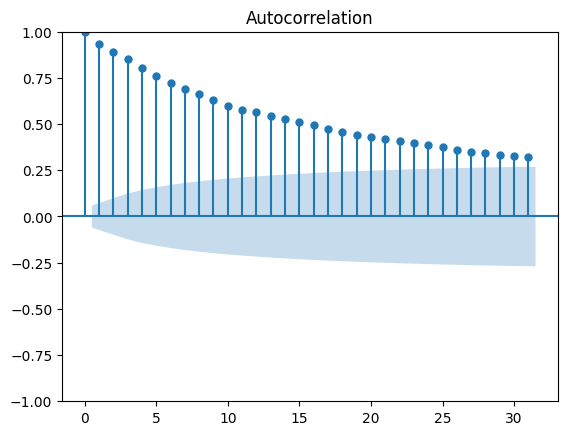

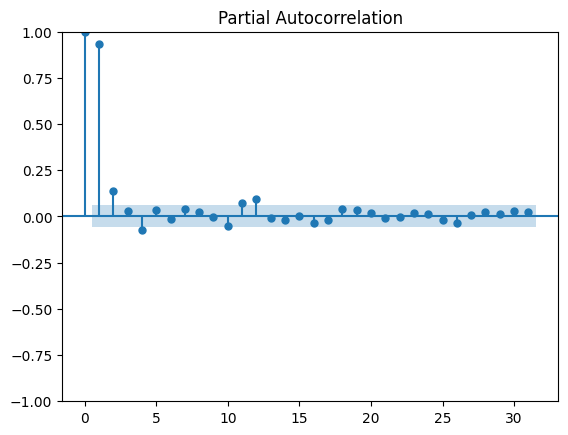

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(arima_ts_train)

pacf_original = plot_pacf(arima_ts_train)

In [31]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(arima_ts_train)
print(f"p-value: ", adftest[1])

p-value:  0.002216682004790684


ARIMA (p,d,q).
*   Stationary, d = 0.
*   Geometric decline in ACF suggests a (p,d,0) model.
*   Significant correlation at 1, 2, 3 and 5 in PACF suggests p in range [2,5].

In [32]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(arima_ts_train, order = (2,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    VIX   No. Observations:                 1081
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2746.867
Date:                Sun, 19 Jan 2025   AIC                           5501.733
Time:                        18:27:27   BIC                           5521.676
Sample:                             0   HQIC                          5509.284
                               - 1081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0492      2.173      9.227      0.000      15.791      24.308
ar.L1          0.8048      0.015     53.796      0.000       0.775       0.834
ar.L2          0.1382      0.016      8.649      0.0

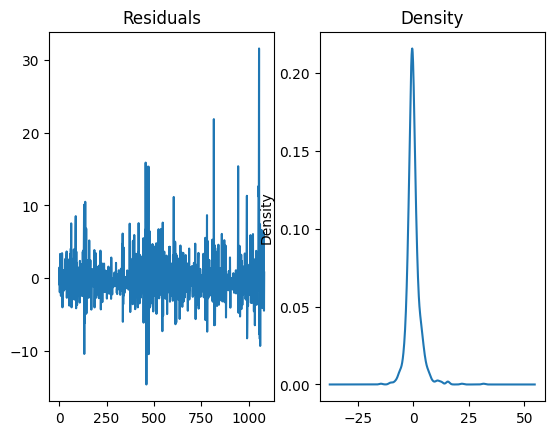

In [33]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax=ax[0])
residuals.plot(title = "Density", kind="kde", ax=ax[1])
plt.show()

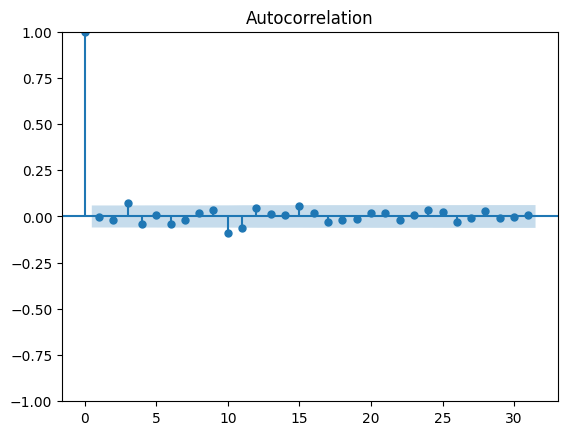

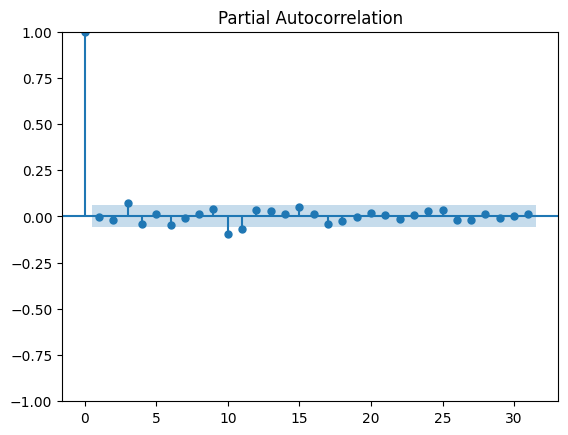

In [34]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

In [36]:
forecast_test = model_fit.forecast(len(arima_ts_test))
#arima_ts = arima_ts.to_frame()
arima_ts.insert(1, "forecast_manual", [None] * (len(arima_ts_train)) + list(forecast_test))

<Axes: >

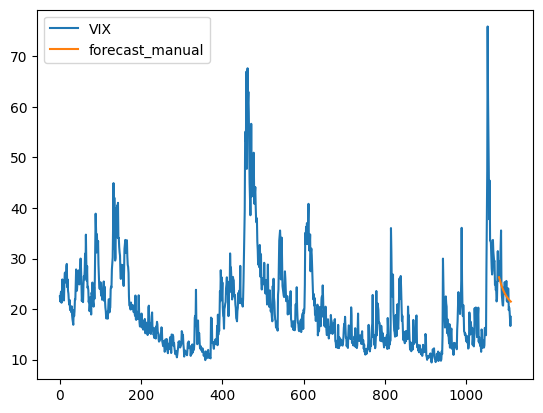

In [37]:
arima_ts.plot()

In [38]:
forecast_test

,predicted_mean
1081,26.296255
1082,26.018097
1083,25.716320
1084,25.435009
1085,25.166904
1086,24.912256
1087,24.670262
1088,24.440313
1089,24.221805
1090,24.014172


In [39]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(arima_ts_test, forecast_test)
mape = mean_absolute_percentage_error(arima_ts_test, forecast_test)
mse = mean_squared_error(arima_ts_test, forecast_test)

In [40]:
print("Mae:", mae)
print("Mape:", mape)
print("Rmse:", np.sqrt(mse))

Mae: 2.307020754478668
Mape: 0.09561715114895156
Rmse: 3.2667149355145413


In [41]:
arima_ts.tail()

,VIX,forecast_manual
1106,20.30,21.801323
1107,19.61,21.714136
1108,18.12,21.631287
1109,16.65,21.552560
1110,18.46,21.477752


                               SARIMAX Results                                
Dep. Variable:                    VIX   No. Observations:                 1081
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2746.867
Date:                Sun, 19 Jan 2025   AIC                           5501.733
Time:                        18:29:16   BIC                           5521.676
Sample:                             0   HQIC                          5509.284
                               - 1081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0492      2.173      9.227      0.000      15.791      24.308
ar.L1          0.8048      0.015     53.796      0.000       0.775       0.834
ar.L2          0.1382      0.016      8.649      0.0

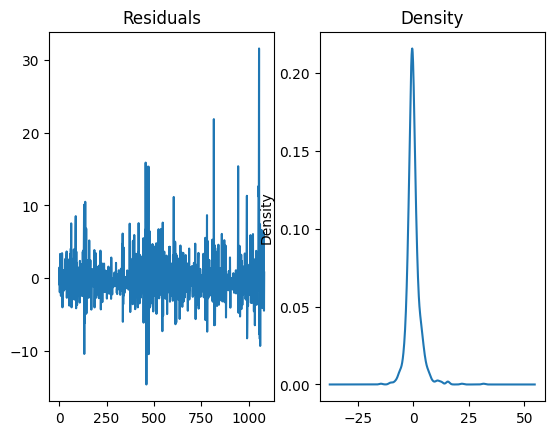

Mae: 2.307020754478668
Mape: 0.09561715114895156
Rmse: 3.2667149355145413
                               SARIMAX Results                                
Dep. Variable:                    VIX   No. Observations:                 1081
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2746.202
Date:                Sun, 19 Jan 2025   AIC                           5502.404
Time:                        18:29:17   BIC                           5527.332
Sample:                             0   HQIC                          5511.843
                               - 1081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0632      2.254      8.903      0.000      15.646      24.480
ar.L1          0.8000      0.015     53.020      0.000   

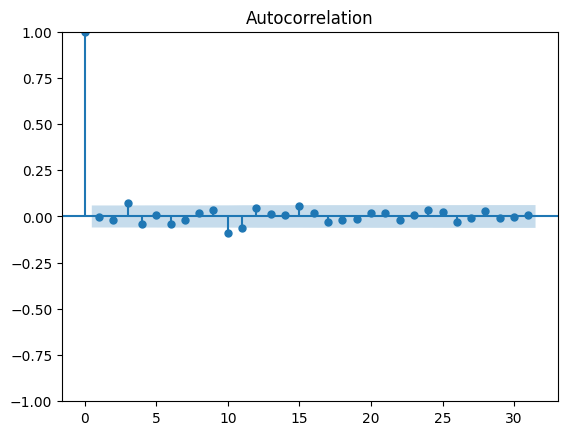

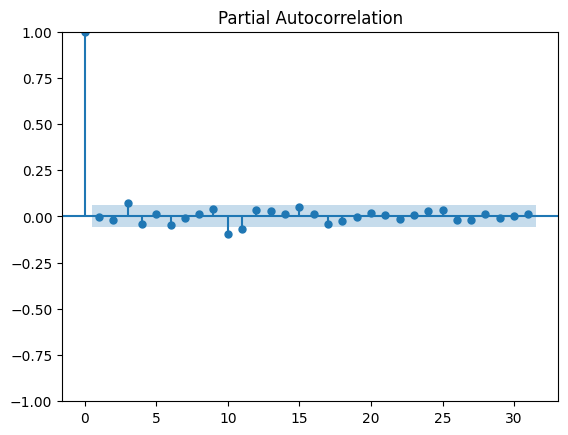

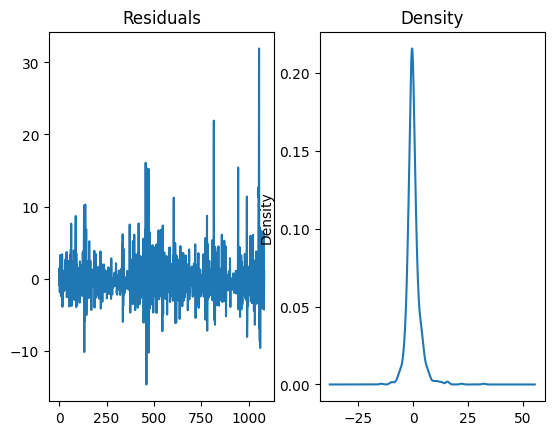

Mae: 2.3168334122297383
Mape: 0.09703097953320701
Rmse: 3.262509972380863
                               SARIMAX Results                                
Dep. Variable:                    VIX   No. Observations:                 1081
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -2743.053
Date:                Sun, 19 Jan 2025   AIC                           5498.106
Time:                        18:29:19   BIC                           5528.020
Sample:                             0   HQIC                          5509.432
                               - 1081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8968      2.103      9.461      0.000      15.775      24.019
ar.L1          0.8026      0.015     53.114      0.000   

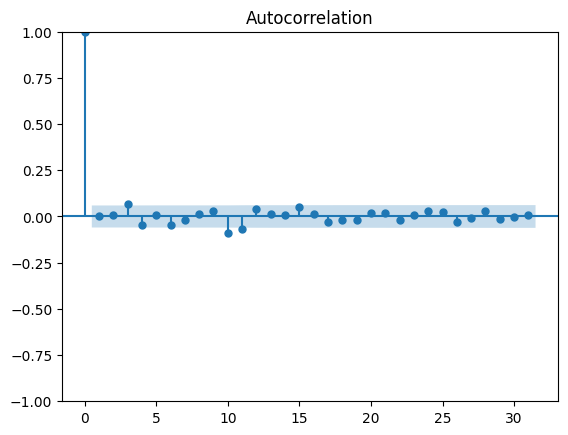

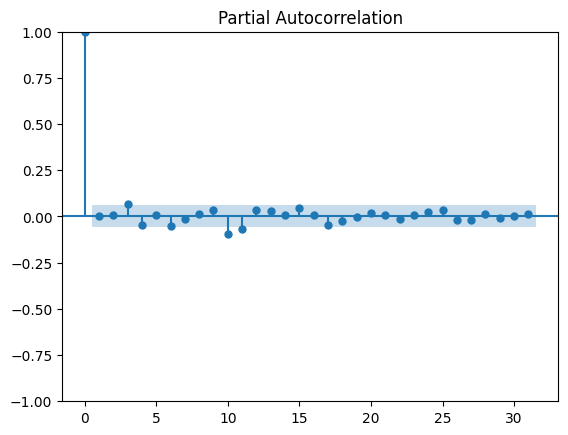

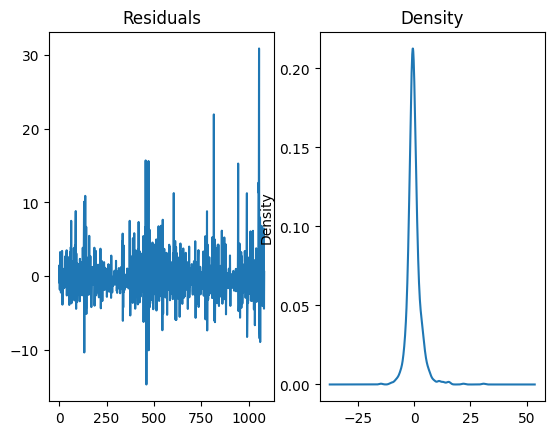

Mae: 2.297901229975639
Mape: 0.09419891559469133
Rmse: 3.2448758736434375
                               SARIMAX Results                                
Dep. Variable:                    VIX   No. Observations:                 1081
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -2742.519
Date:                Sun, 19 Jan 2025   AIC                           5499.037
Time:                        18:29:21   BIC                           5533.937
Sample:                             0   HQIC                          5512.251
                               - 1081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0442      2.163      9.265      0.000      15.804      24.285
ar.L1          0.8051      0.015     52.512      0.000   

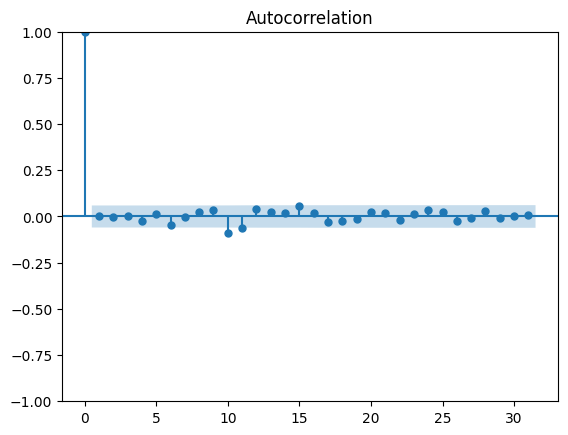

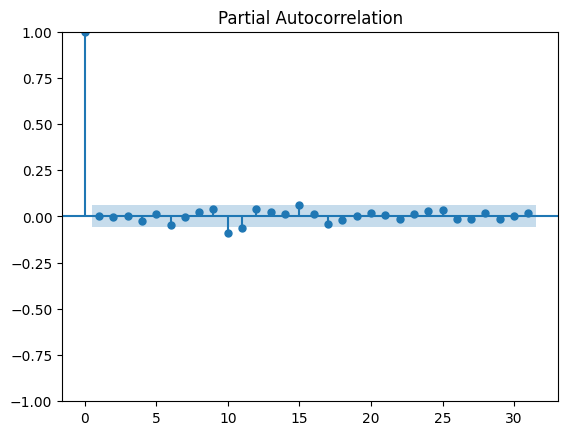

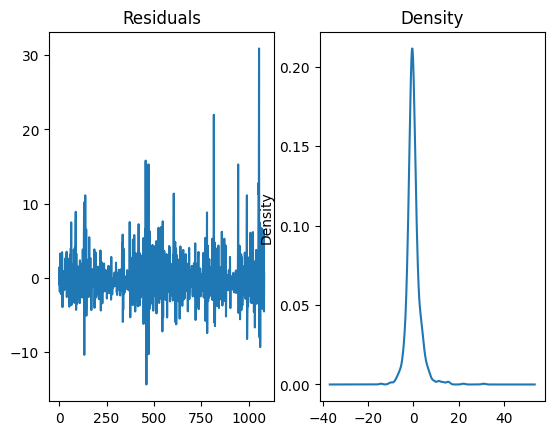

Mae: 2.3241214303881095
Mape: 0.09599822960663136
Rmse: 3.2771466159068336


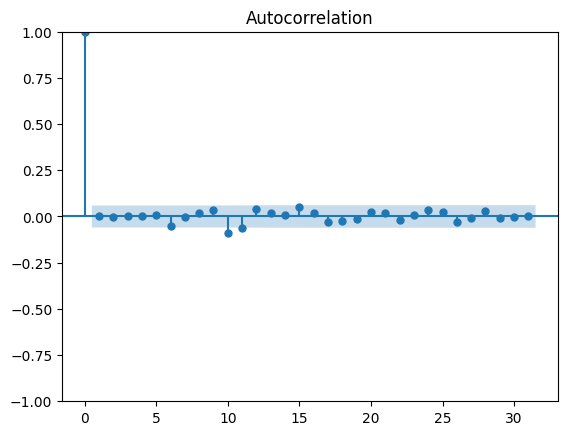

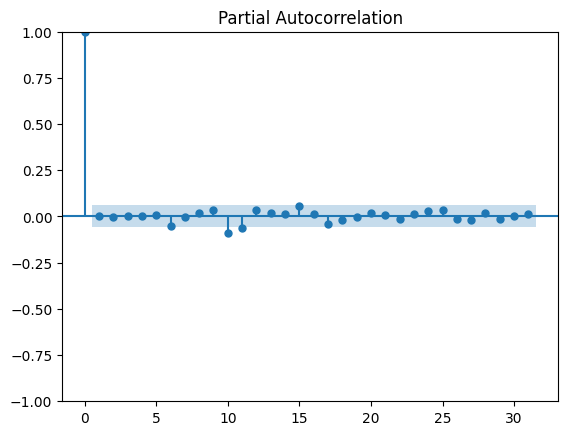

In [42]:
for p in range(2,6):
  model = ARIMA(arima_ts_train, order = (p,0,0))
  model_fit = model.fit()
  print(model_fit.summary())

  # residuals = model_fit.resid[1:]
  # fig, ax = plt.subplots(1,2)
  # residuals.plot(title = "Residuals", ax=ax[0])
  # residuals.plot(title = "Density", kind="kde", ax=ax[1])
  # plt.show()

  # acf_res = plot_acf(residuals)

  # pacf_res = plot_pacf(residuals)

  forecast_test = model_fit.forecast(len(arima_ts_test))

  mae = mean_absolute_error(arima_ts_test, forecast_test)
  mape = mean_absolute_percentage_error(arima_ts_test, forecast_test)
  mse = mean_squared_error(arima_ts_test, forecast_test)

  print("Mae:", mae)
  print("Mape:", mape)
  print("Rmse:", np.sqrt(mse))

#### ARIMA Results Summary:

| AR(p=) | MAE | MAPE | RMSE |
|---|---|---|---|
| 2 | 2.317 | 0.097 | 3.263 |
| 3 | 2.317 | 0.097 | 3.263 |
| 4 | 2.298 | 0.094 | 3.245 |
| 5 | 2.324 | 0.096 | 3.277 |                  

#### Final Model Results

In [79]:
model = ARIMA(financial_market_data["VIX"], order = (4,0,0))
model_fit = model.fit()
print(model_fit.summary())

residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax=ax[0])
residuals.plot(title = "Density", kind="kde", ax=ax[1])
plt.show()

acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

forecast_test = model_fit.forecast(len(arima_ts_test))

mae = mean_absolute_error(arima_ts_test, forecast_test)
mape = mean_absolute_percentage_error(arima_ts_test, forecast_test)
mse = mean_squared_error(arima_ts_test, forecast_test)

print("Mae:", mae)
print("Mape:", mape)
print("Rmse:", np.sqrt(mse))

                               SARIMAX Results                                
Dep. Variable:                    VIX   No. Observations:                 1111
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -2817.143
Date:                Sun, 19 Jan 2025   AIC                           5646.286
Time:                        19:00:07   BIC                           5676.364
Sample:                             0   HQIC                          5657.659
                               - 1111                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9924      2.043      9.787      0.000      15.989      23.996
ar.L1          0.8039      0.015     53.502      0.000       0.774       0.833
ar.L2          0.1136      0.021      5.295      0.0

### ARIMA :1yr

Checking for stationarity

In [61]:
arima_ts = financial_market_data["VIX"]

In [62]:
arima_ts.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1111 entries, 0 to 1110
Series name: VIX
Non-Null Count  Dtype  
--------------  -----  
1111 non-null   float64
dtypes: float64(1)
memory usage: 8.8 KB


<Axes: >

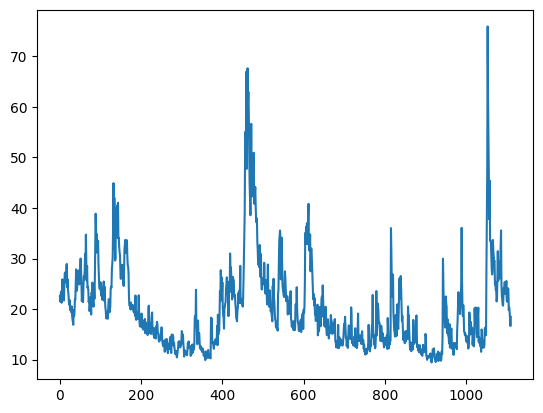

In [63]:
arima_ts.plot()

<Axes: >

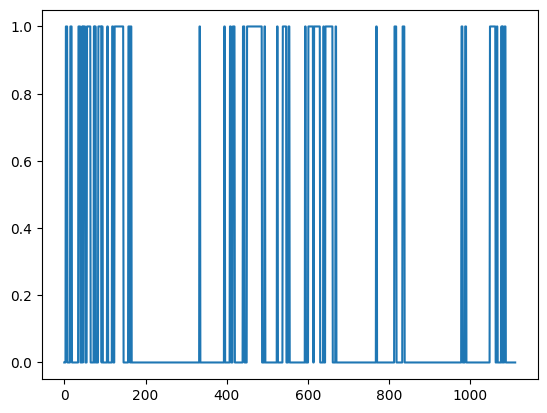

In [64]:
financial_market_data["Y"].plot()

In [65]:
msk = (arima_ts.index < len(arima_ts)-52)
arima_ts_train = arima_ts[msk].copy()
arima_ts_test = arima_ts[~msk].copy()

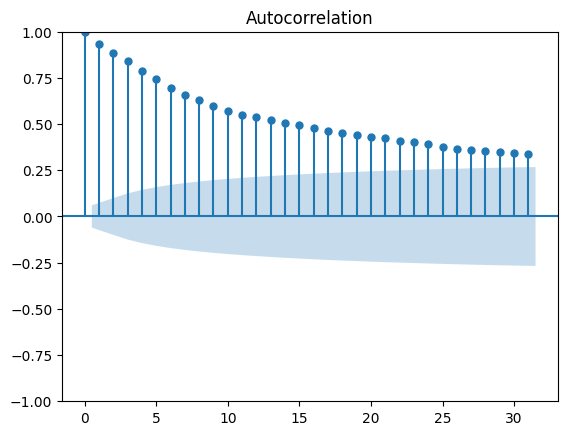

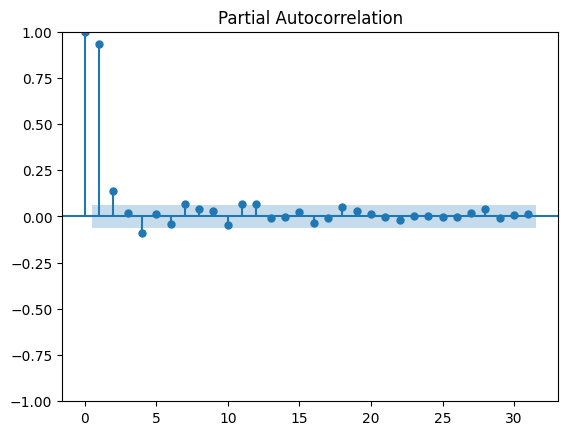

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(arima_ts_train)

pacf_original = plot_pacf(arima_ts_train)

In [67]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(arima_ts_train)
print(f"p-value: ", adftest[1])

p-value:  0.007176985441772615


ARIMA (p,d,q).
*   Stationary, d = 0.
*   Geometric decline in ACF suggests a (p,d,0) model.
*   Significant correlation at 1, 2, 3 and 5 in PACF suggests p in range [2,5].

In [68]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(arima_ts_train, order = (2,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    VIX   No. Observations:                 1059
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2688.848
Date:                Sun, 19 Jan 2025   AIC                           5385.695
Time:                        18:37:40   BIC                           5405.555
Sample:                             0   HQIC                          5393.222
                               - 1059                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.2275      2.327      8.691      0.000      15.666      24.789
ar.L1          0.8120      0.015     54.494      0.000       0.783       0.841
ar.L2          0.1348      0.016      8.469      0.0

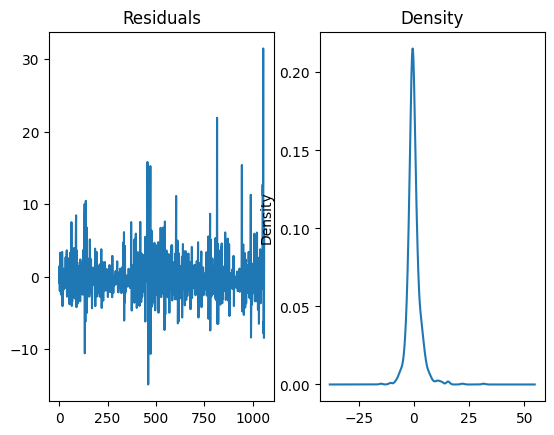

In [69]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax=ax[0])
residuals.plot(title = "Density", kind="kde", ax=ax[1])
plt.show()

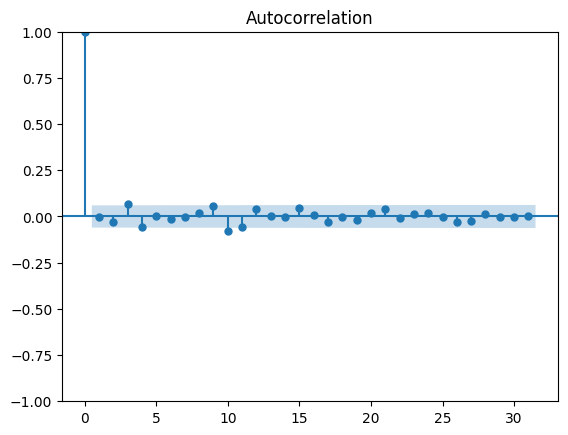

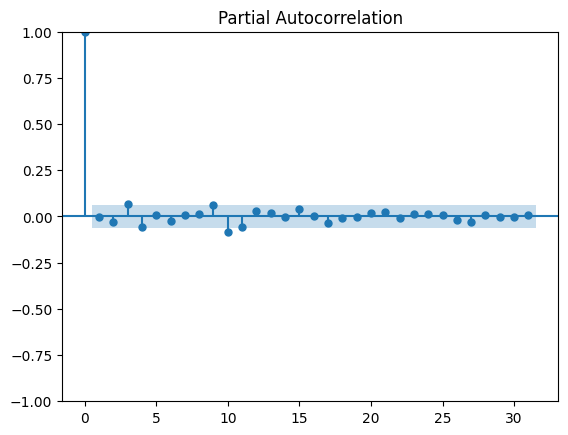

In [70]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

In [71]:
forecast_test = model_fit.forecast(len(arima_ts_test))
arima_ts = arima_ts.to_frame()
arima_ts.insert(1, "forecast_manual", [None] * (len(arima_ts_train)) + list(forecast_test))

<Axes: >

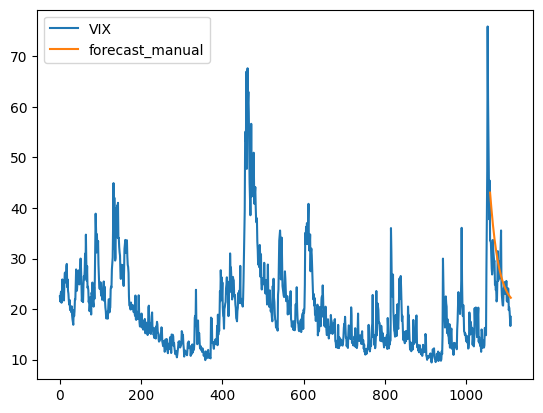

In [72]:
arima_ts.plot()

In [73]:
forecast_test

,predicted_mean
1059,43.037148
1060,42.141354
1061,41.094259
1062,40.123354
1063,39.193921
1064,38.308430
1065,37.464207
1066,36.659411
1067,35.892191
1068,35.160793


In [74]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(arima_ts_test, forecast_test)
mape = mean_absolute_percentage_error(arima_ts_test, forecast_test)
mse = mean_squared_error(arima_ts_test, forecast_test)

In [75]:
print("Mae:", mae)
print("Mape:", mape)
print("Rmse:", np.sqrt(mse))

Mae: 4.376542682626033
Mape: 0.17069382104638425
Rmse: 5.411499713065476


In [76]:
arima_ts.tail()

,VIX,forecast_manual
1106,20.30,22.654313
1107,19.61,22.541002
1108,18.12,22.432982
1109,16.65,22.330006
1110,18.46,22.231837


In [78]:
for p in range(2,6):
  model = ARIMA(arima_ts_train, order = (p,0,0))
  model_fit = model.fit()
  print(model_fit.summary())

  # residuals = model_fit.resid[1:]
  # fig, ax = plt.subplots(1,2)
  # residuals.plot(title = "Residuals", ax=ax[0])
  # residuals.plot(title = "Density", kind="kde", ax=ax[1])
  # plt.show()

  # acf_res = plot_acf(residuals)

  # pacf_res = plot_pacf(residuals)

  forecast_test = model_fit.forecast(len(arima_ts_test))

  mae = mean_absolute_error(arima_ts_test, forecast_test)
  mape = mean_absolute_percentage_error(arima_ts_test, forecast_test)
  mse = mean_squared_error(arima_ts_test, forecast_test)

  print("Mae:", mae)
  print("Mape:", mape)
  print("Rmse:", np.sqrt(mse))

                               SARIMAX Results                                
Dep. Variable:                    VIX   No. Observations:                 1059
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2688.848
Date:                Sun, 19 Jan 2025   AIC                           5385.695
Time:                        18:40:12   BIC                           5405.555
Sample:                             0   HQIC                          5393.222
                               - 1059                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.2275      2.327      8.691      0.000      15.666      24.789
ar.L1          0.8120      0.015     54.494      0.000       0.783       0.841
ar.L2          0.1348      0.016      8.469      0.0

#### ARIMA Results Summary:

| AR(p=) | MAE | MAPE | RMSE |
|---|---|---|---|
| 2 | 4.378 | 0.170 | 5.411 |
| 3 | 4.815 | 0.190 | 5.822 |
| 4 | 3.947 | 0.153 | 5.002 |
| 5 | 4.693 | 0.184 | 5.725 |                  

                               SARIMAX Results                                
Dep. Variable:                    VIX   No. Observations:                 1111
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -2817.143
Date:                Sun, 19 Jan 2025   AIC                           5646.286
Time:                        13:33:43   BIC                           5676.364
Sample:                             0   HQIC                          5657.659
                               - 1111                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9924      2.043      9.787      0.000      15.989      23.996
ar.L1          0.8039      0.015     53.502      0.000       0.774       0.833
ar.L2          0.1136      0.021      5.295      0.0

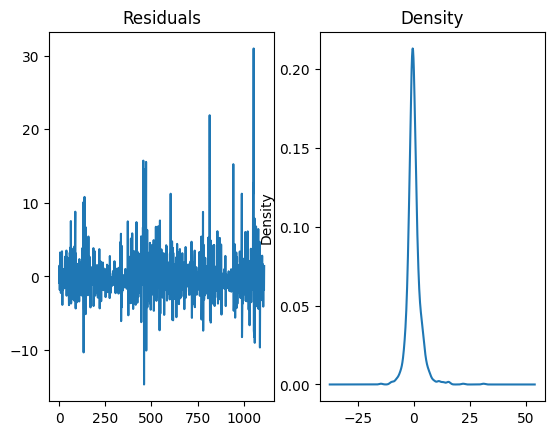

Mae: 4.877512418119313
Mape: 0.1877327249701359
Rmse: 6.300842273023865


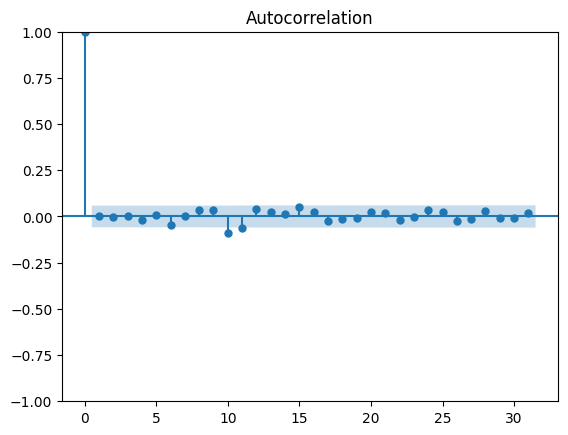

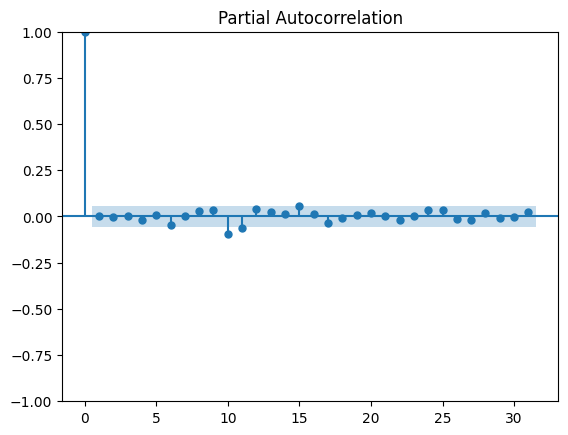

In [ ]:
model = ARIMA(financial_market_data["VIX"], order = (4,0,0))
model_fit = model.fit()
print(model_fit.summary())



# residuals = model_fit.resid[1:]
# fig, ax = plt.subplots(1,2)
# residuals.plot(title = "Residuals", ax=ax[0])
# residuals.plot(title = "Density", kind="kde", ax=ax[1])
# plt.show()

# acf_res = plot_acf(residuals)

# pacf_res = plot_pacf(residuals)

# forecast_test = model_fit.forecast(len(arima_ts_test))

# mae = mean_absolute_error(arima_ts_test, forecast_test)
# mape = mean_absolute_percentage_error(arima_ts_test, forecast_test)
# mse = mean_squared_error(arima_ts_test, forecast_test)

# print("Mae:", mae)
# print("Mape:", mape)
# print("Rmse:", np.sqrt(mse))

In [95]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




### VARMAX

In [64]:
lagged_data = financial_market_data.copy(deep=True)
lagged_data = lagged_data.drop(["Y","Data"], axis=1)

In [65]:
lagged_data.head()

,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,283.25,0.077,1388.0,157.26,100.56,105.86,1.646,25.77,22.50,6.671,...,116.464,230.527,123.762,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,287.65,0.043,1405.0,165.01,101.86,105.47,1.638,28.85,21.50,6.747,...,117.267,231.377,123.762,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,287.15,0.135,1368.0,167.24,102.41,106.04,1.650,28.28,23.02,6.634,...,117.995,232.390,123.762,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,282.75,0.191,1311.0,166.85,104.92,107.85,1.611,28.22,23.45,6.423,...,120.510,231.942,122.328,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,298.40,0.312,1277.0,165.43,104.22,109.30,1.611,28.02,21.25,6.231,...,118.791,237.812,122.328,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32


In [66]:
for col in lagged_data.columns:
  if col != "VIX":
    # print('VIX causes', col, '?\n')
    # print('------------------')
    # granger_1 = grangercausalitytests(lagged_data[[col, 'VIX']], 4)

    print(col, ' causes VIX?\n')
    print('------------------')
    granger_2 = grangercausalitytests(lagged_data[['VIX', col]], 4)

XAU BGNL  causes VIX?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2604  , p=0.6100  , df_denom=1107, df_num=1
ssr based chi2 test:   chi2=0.2611  , p=0.6094  , df=1
likelihood ratio test: chi2=0.2611  , p=0.6094  , df=1
parameter F test:         F=0.2604  , p=0.6100  , df_denom=1107, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2038  , p=0.3004  , df_denom=1104, df_num=2
ssr based chi2 test:   chi2=2.4185  , p=0.2984  , df=2
likelihood ratio test: chi2=2.4159  , p=0.2988  , df=2
parameter F test:         F=1.2038  , p=0.3004  , df_denom=1104, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3171  , p=0.0741  , df_denom=1101, df_num=3
ssr based chi2 test:   chi2=6.9955  , p=0.0720  , df=3
likelihood ratio test: chi2=6.9735  , p=0.0727  , df=3
parameter F test:         F=2.3171  , p=0.0741  , df_denom=1101, df_num=3

Granger Causality
number of lags (no zero) 4


* VIX: Volatality Index
* JPY: Japanese Yen
* USGG3M:Treasury bill 0-3 months
* LMBITR: Municipal Bond

In [117]:
for col in [ "JPY", "USGG3M", "LMBITR"]:
    # print('VIX causes', col, '?\n')
    # print('------------------')
    # granger_1 = grangercausalitytests(lagged_data[[col, 'VIX']], 4)

    print(col, ' causes VIX?\n')
    print('------------------')
    granger_2 = grangercausalitytests(lagged_data[['VIX', col]], 4)

JPY  causes VIX?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0044  , p=0.9474  , df_denom=1107, df_num=1
ssr based chi2 test:   chi2=0.0044  , p=0.9473  , df=1
likelihood ratio test: chi2=0.0044  , p=0.9473  , df=1
parameter F test:         F=0.0044  , p=0.9474  , df_denom=1107, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5060  , p=0.0821  , df_denom=1104, df_num=2
ssr based chi2 test:   chi2=5.0347  , p=0.0807  , df=2
likelihood ratio test: chi2=5.0233  , p=0.0811  , df=2
parameter F test:         F=2.5060  , p=0.0821  , df_denom=1104, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3814  , p=0.0680  , df_denom=1101, df_num=3
ssr based chi2 test:   chi2=7.1897  , p=0.0661  , df=3
likelihood ratio test: chi2=7.1664  , p=0.0668  , df=3
parameter F test:         F=2.3814  , p=0.0680  , df_denom=1101, df_num=3

Granger Causality
number of lags (no zero) 4
ssr b

In [67]:
train_df=lagged_data[["VIX", "JPY", "USGG3M", "LMBITR"]][:-26]
test_df=lagged_data[["VIX", "JPY", "USGG3M", "LMBITR"]][-26:]

In [114]:
for col in lagged_data.columns:
  ad_fuller_result_1 = adfuller(lagged_data[col].diff()[1:])

  print(col)
  print(f'ADF Statistic: {ad_fuller_result_1[0]}')
  print(f'p-value: {ad_fuller_result_1[1]}')

  print('\n---------------------\n')

XAU BGNL
ADF Statistic: -35.51355995234211
p-value: 0.0

---------------------

ECSURPUS
ADF Statistic: -9.498942526904056
p-value: 3.4871618718962916e-16

---------------------

BDIY
ADF Statistic: -8.424736650670964
p-value: 1.9405702303193223e-13

---------------------

CRY
ADF Statistic: -9.651219900979791
p-value: 1.4330406247575433e-16

---------------------

DXY
ADF Statistic: -33.49478623028068
p-value: 0.0

---------------------

JPY
ADF Statistic: -33.15041847978296
p-value: 0.0

---------------------

GBP
ADF Statistic: -34.01192454138829
p-value: 0.0

---------------------

Cl1
ADF Statistic: -13.030317717028277
p-value: 2.352439172547718e-24

---------------------

VIX
ADF Statistic: -13.09350625942364
p-value: 1.768577953365114e-24

---------------------

USGG30YR
ADF Statistic: -14.840041567072456
p-value: 1.843067837732661e-27

---------------------

GT10
ADF Statistic: -33.7952641523616
p-value: 0.0

---------------------

USGG2YR
ADF Statistic: -11.42749038896606
p-va

In [118]:
ad_fuller_result_1 = adfuller(lagged_data['VIX'])#.diff()[1:])

print('VIX')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(lagged_data['JPY'].diff()[1:])

print('JPY')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(lagged_data['USGG3M'].diff()[1:])

print('USGG3M')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(lagged_data['LMBITR'].diff()[1:])

print('LMBITR')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

print('\n---------------------\n')

VIX
ADF Statistic: -3.971067320899327
p-value: 0.0015698233817825573

---------------------

JPY
ADF Statistic: -33.15041847978296
p-value: 0.0

---------------------

USGG3M
ADF Statistic: -4.856829127377103
p-value: 4.2289112104817936e-05

---------------------

LMBITR
ADF Statistic: -18.688869113125786
p-value: 2.039874978247444e-30

---------------------



In [69]:
model = VAR(train_df.diff()[1:])

In [70]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.627       1.645       5.086       1.634
1        1.489      1.582*       4.431      1.524*
2        1.480       1.648       4.391       1.543
3        1.456       1.699       4.290       1.548
4       1.454*       1.771      4.278*       1.574
5        1.473       1.865       4.361       1.621
6        1.471       1.938       4.355       1.648
7        1.458       2.000       4.299       1.664
8        1.464       2.081       4.324       1.698
9        1.478       2.169       4.384       1.740
10       1.487       2.253       4.425       1.777
11       1.494       2.335       4.457       1.813
12       1.505       2.421       4.506       1.852
13       1.498       2.488       4.473       1.873
14       1.515       2.580       4.552       1.919
15       1.537       2.677       4.652       1.969
16       1.534       2.749     

In [71]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                   Statespace Model Results                                   
Dep. Variable:     ['VIX', 'JPY', 'USGG3M', 'LMBITR']   No. Observations:                 1085
Model:                                         VAR(4)   Log Likelihood             -127726.374
                                          + intercept   AIC                         255608.749
Date:                                Mon, 20 Jan 2025   BIC                         255997.917
Time:                                        01:48:04   HQIC                        255756.073
Sample:                                             0                                         
                                               - 1085                                         
Covariance Type:                                  opg                                         
Ljung-Box (L1) (Q):     849.96, 1066.28, 1081.23, 1059.68   Jarque-Bera (JB):   4983.88, 47.96, 93.83, 1.18
Prob(Q):                           0.

In [72]:
var_model = VARMAX(train_df, order=(7,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                   Statespace Model Results                                   
Dep. Variable:     ['VIX', 'JPY', 'USGG3M', 'LMBITR']   No. Observations:                 1085
Model:                                         VAR(7)   Log Likelihood             -167033.807
                                          + intercept   AIC                         334319.615
Date:                                Mon, 20 Jan 2025   BIC                         334948.271
Time:                                        01:50:01   HQIC                        334557.600
Sample:                                             0                                         
                                               - 1085                                         
Covariance Type:                                  opg                                         
Ljung-Box (L1) (Q):     891.67, 1067.41, 984.06, 1048.76   Jarque-Bera (JB):   4405.20, 76.72, 3.36, 3.89
Prob(Q):                          0.00,

In [73]:
n_forecast = 26
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)
predictions=predict.predicted_mean

In [74]:
predictions.columns=['VIX_predicted', 'JPY_predicted', 'USGG3M_predicted', 'LMBITR_predicted']
predictions

,VIX_predicted,JPY_predicted,USGG3M_predicted,LMBITR_predicted
1085,20.252850,99.289753,0.731226,1226.629216
1086,18.772196,94.802905,-2.362797,1345.863088
1087,18.741992,97.301568,-0.115659,1268.786035
1088,18.967063,98.185363,0.535590,1252.466983
1089,19.037100,97.581715,-0.121656,1277.978127
1090,18.868219,97.586301,-0.402730,1289.041502
1091,18.818258,98.472349,-0.029342,1277.915552
1092,18.773602,99.538957,0.330603,1271.438086
1093,18.908417,99.862613,0.595513,1264.789790
1094,19.200153,99.689287,0.217869,1271.601999


In [75]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

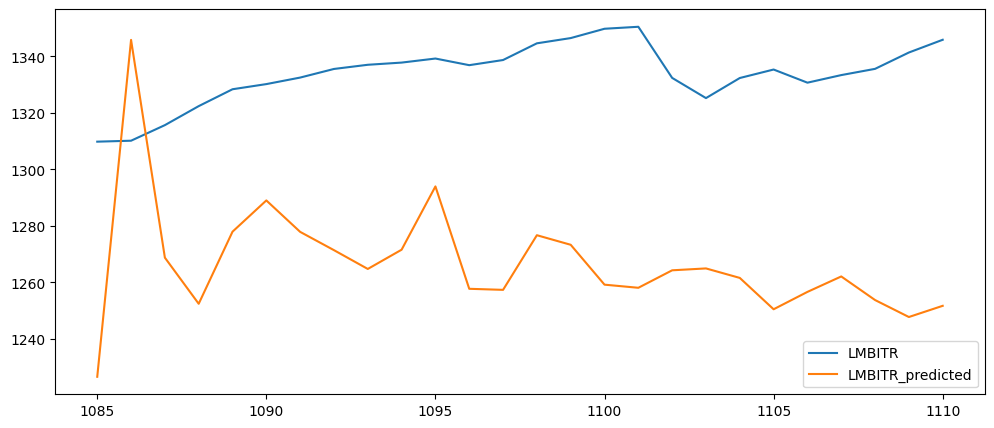

In [76]:
test_vs_pred[["LMBITR", "LMBITR_predicted"]].plot(figsize=(12,5))

<Axes: >

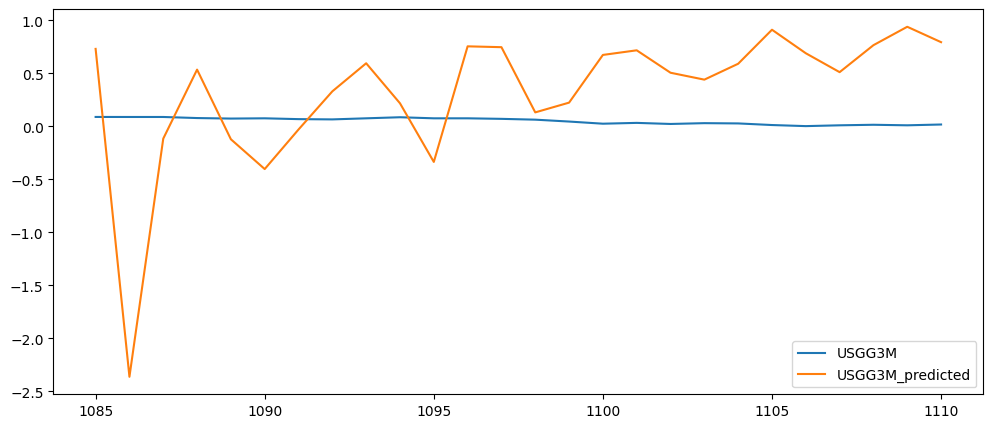

In [77]:
test_vs_pred[["USGG3M", "USGG3M_predicted"]].plot(figsize=(12,5))

<Axes: >

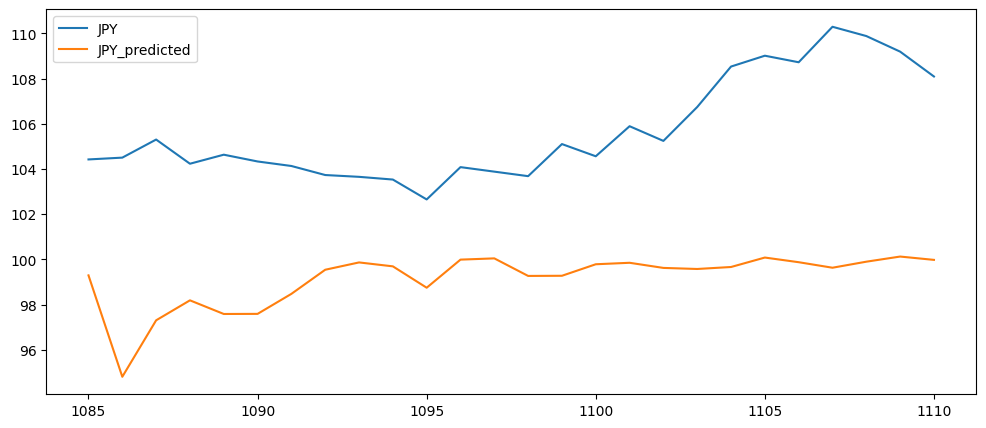

In [78]:
test_vs_pred[["JPY", "JPY_predicted"]].plot(figsize=(12,5))

<Axes: >

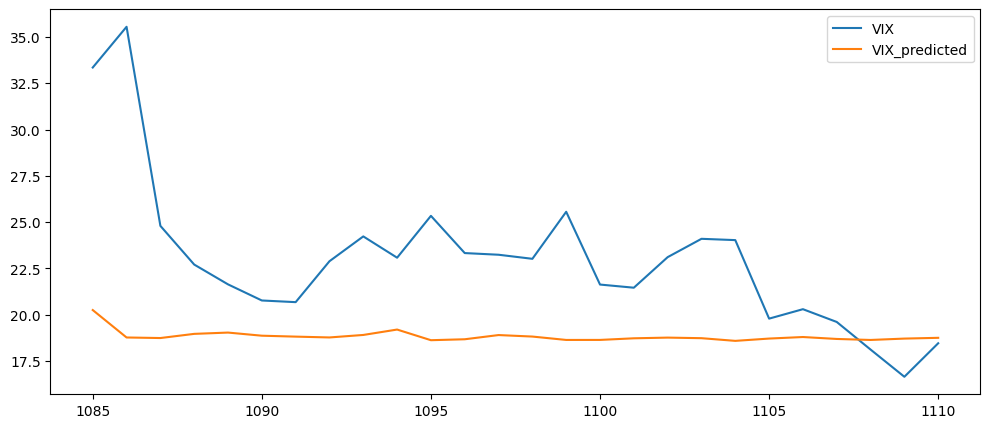

In [79]:
test_vs_pred[["VIX", "VIX_predicted"]].plot(figsize=(12,5))

## Dataset Prep

In [91]:
X = financial_market_data[["VIX", "JPY", "USGG3M", "LMBITR"]]
y = financial_market_data[["Y"]]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## Classification Models

### Logistic Regression

In [93]:
solvers = ["lbfgs", "sag", "saga", "liblinear", "newton-cholesky"]


In [94]:
for solver in solvers:
  print("For solver:", solver)
  model = LogisticRegression(class_weight="balanced", solver=solver, random_state=42, max_iter=2000)
  clf = model.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_pred, y_test))

For solver: lbfgs
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       226
           1       0.82      0.54      0.65       108

    accuracy                           0.81       334
   macro avg       0.81      0.74      0.76       334
weighted avg       0.81      0.81      0.80       334

For solver: sag


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.82      0.94      0.88       228
           1       0.82      0.55      0.66       106

    accuracy                           0.82       334
   macro avg       0.82      0.75      0.77       334
weighted avg       0.82      0.82      0.81       334

For solver: saga
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       227
           1       0.82      0.54      0.65       107

    accuracy                           0.81       334
   macro avg       0.82      0.74      0.76       334
weighted avg       0.81      0.81      0.80       334

For solver: liblinear
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       227
           1       0.82      0.54      0.65       107

    accuracy                           0.81       334
   macro avg       0.82      0.74      0.76       334
weighted avg       0.81      0.81  

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Isolation Forest

In [95]:
if_model = IsolationForest(n_estimators=200 ,contamination=0.21 ,random_state=42)
preds = if_model.fit_predict(X)
y_pred = np.where(preds == -1,1,0)

In [96]:
print(classification_report(y_pred, y))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       877
           1       0.51      0.52      0.51       234

    accuracy                           0.79      1111
   macro avg       0.69      0.69      0.69      1111
weighted avg       0.79      0.79      0.79      1111



### Decision Tree


In [97]:
from sklearn.tree import DecisionTreeClassifier

In [98]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       263
           1       0.70      0.73      0.72        71

    accuracy                           0.88       334
   macro avg       0.81      0.82      0.82       334
weighted avg       0.88      0.88      0.88       334



### Random Forest Classifier

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       263
           1       0.82      0.65      0.72        71

    accuracy                           0.90       334
   macro avg       0.87      0.80      0.83       334
weighted avg       0.89      0.90      0.89       334



### K-Nearest Neighbours : KNN

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [104]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       263
           1       0.82      0.56      0.67        71

    accuracy                           0.88       334
   macro avg       0.85      0.76      0.80       334
weighted avg       0.88      0.88      0.87       334



In [106]:
pipe = make_pipeline(StandardScaler(), knn_model)
pipe.fit(X_train, y_train)  # apply scaling on training data
#Pipeline(steps=[('standardscaler', StandardScaler()),
#                ('logisticregression', LogisticRegression())])

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       263
           1       0.75      0.62      0.68        71

    accuracy                           0.87       334
   macro avg       0.82      0.78      0.80       334
weighted avg       0.87      0.87      0.87       334



/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### Naive Bayes

In [107]:
from sklearn.naive_bayes import GaussianNB

In [108]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [109]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       263
           1       0.79      0.48      0.60        71

    accuracy                           0.86       334
   macro avg       0.83      0.72      0.76       334
weighted avg       0.86      0.86      0.85       334



### Gradient Boosting Machine

In [110]:
from sklearn.ensemble import GradientBoostingClassifier

In [111]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [112]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       263
           1       0.80      0.68      0.73        71

    accuracy                           0.90       334
   macro avg       0.86      0.82      0.83       334
weighted avg       0.89      0.90      0.89       334



# Investment Strategy:



# Appendix:

## TSFresh for Time-Series Classification

### EDA and Feature Extraction

In [103]:
time_series_data_tsf = financial_market_data[["Data", "VIX"]]

In [104]:
target_tsf = financial_market_data[["Y"]]

In [105]:
time_series_data_tsf = time_series_data_tsf.rename(columns = {"Data": "Date"})

In [106]:
time_series_data_tsf["Date"] = pd.to_datetime(time_series_data_tsf["Date"])

In [107]:
time_series_data_tsf["id"] = time_series_data_tsf.index + 1

In [108]:
time_series_data_tsf.head(), target_tsf.head()

(        Date    VIX  id
 0 2000-01-11  22.50   1
 1 2000-01-18  21.50   2
 2 2000-01-25  23.02   3
 3 2000-02-01  23.45   4
 4 2000-02-08  21.25   5,
    Y
 0  0
 1  0
 2  0
 3  0
 4  1)

In [109]:
X_tsf = extract_features(time_series_data_tsf, column_id="id", column_sort="Date", impute_function=impute)

Feature Extraction: 100%|██████████| 1111/1111 [01:28<00:00, 12.49it/s]


In [110]:
X_tsf.head()

,VIX__variance_larger_than_standard_deviation,VIX__has_duplicate_max,VIX__has_duplicate_min,VIX__has_duplicate,VIX__sum_values,VIX__abs_energy,VIX__mean_abs_change,VIX__mean_change,VIX__mean_second_derivative_central,VIX__median,...,VIX__fourier_entropy__bins_5,VIX__fourier_entropy__bins_10,VIX__fourier_entropy__bins_100,VIX__permutation_entropy__dimension_3__tau_1,VIX__permutation_entropy__dimension_4__tau_1,VIX__permutation_entropy__dimension_5__tau_1,VIX__permutation_entropy__dimension_6__tau_1,VIX__permutation_entropy__dimension_7__tau_1,VIX__query_similarity_count__query_None__threshold_0.0,VIX__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,0.0,0.0,22.50,506.2500,0.0,0.0,0.0,22.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,21.50,462.2500,0.0,0.0,0.0,21.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,23.02,529.9204,0.0,0.0,0.0,23.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,23.45,549.9025,0.0,0.0,0.0,23.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,21.25,451.5625,0.0,0.0,0.0,21.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
X_tsf.index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111],
      dtype='int64', length=1111)

In [112]:
target_tsf.index = target_tsf.index.values + 1

In [113]:
index_equal = X_tsf.index.equals(target_tsf["Y"].index)

print(index_equal)

True


In [114]:
cnt = 0

for col in X_tsf.columns:
  if "VIX" in col:
    cnt += 1

print(cnt)

783


In [115]:
type(target_tsf["Y"]), target_tsf.shape

(pandas.core.series.Series, (1111, 1))

In [116]:
X_filtered = select_features(X_tsf, target_tsf["Y"])

In [117]:
X_filtered.head()

,VIX__sum_values,"VIX__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","VIX__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","VIX__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","VIX__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",VIX__quantile__q_0.9,VIX__quantile__q_0.8,VIX__quantile__q_0.7,VIX__quantile__q_0.6,VIX__quantile__q_0.4,...,VIX__minimum,VIX__absolute_maximum,VIX__maximum,VIX__root_mean_square,VIX__mean,VIX__median,VIX__abs_energy,VIX__quantile__q_0.2,"VIX__fft_coefficient__attr_""abs""__coeff_0",VIX__benford_correlation
1,22.50,4.363645,6.171126,8.727290,13.799057,22.50,22.50,22.50,22.50,22.50,...,22.50,22.50,22.50,22.50,22.50,22.50,506.2500,22.50,22.50,0.295657
2,21.50,4.169705,5.896854,8.339411,13.185766,21.50,21.50,21.50,21.50,21.50,...,21.50,21.50,21.50,21.50,21.50,21.50,462.2500,21.50,21.50,0.295657
3,23.02,4.464494,6.313748,8.928988,14.117969,23.02,23.02,23.02,23.02,23.02,...,23.02,23.02,23.02,23.02,23.02,23.02,529.9204,23.02,23.02,0.295657
4,23.45,4.547888,6.431685,9.095776,14.381684,23.45,23.45,23.45,23.45,23.45,...,23.45,23.45,23.45,23.45,23.45,23.45,549.9025,23.45,23.45,0.295657
5,21.25,4.121220,5.828286,8.242441,13.032443,21.25,21.25,21.25,21.25,21.25,...,21.25,21.25,21.25,21.25,21.25,21.25,451.5625,21.25,21.25,0.295657


In [118]:
y = target_tsf["Y"]

In [119]:
y.shape

(1111,)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.33, stratify=y, random_state=42)

### Logistic Regression

In [121]:
solvers = ["lbfgs", "sag", "saga", "liblinear", "newton-cholesky"]


In [122]:
for solver in solvers:
  print("For solver:", solver)
  model = LogisticRegression(class_weight="balanced", solver=solver, random_state=42, max_iter=10000)
  clf = model.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))

For solver: lbfgs
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       263
           1       0.55      0.79      0.65        71

    accuracy                           0.82       334
   macro avg       0.75      0.81      0.77       334
weighted avg       0.85      0.82      0.83       334

For solver: sag
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       263
           1       0.61      0.72      0.66        71

    accuracy                           0.84       334
   macro avg       0.77      0.80      0.78       334
weighted avg       0.86      0.84      0.85       334

For solver: saga
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       263
           1       0.61      0.72      0.66        71

    accuracy                           0.84       334
   macro avg       0.77      0.80      0.78       334
weighted avg       0.86

In [123]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [124]:
solvers = ["lbfgs", "sag", "saga", "liblinear", "newton-cholesky"]


In [125]:
for solver in solvers:
  print("For solver:", solver)
  model = LogisticRegression(class_weight="balanced", solver=solver, random_state=42, max_iter=10000)
  pipe = make_pipeline(StandardScaler(), model)
  pipe.fit(X_train, y_train)  # apply scaling on training data
  #Pipeline(steps=[('standardscaler', StandardScaler()),
  #              ('logisticregression', model)])

  print(classification_report(y_test, pipe.predict(X_test)))

For solver: lbfgs
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       263
           1       0.55      0.79      0.65        71

    accuracy                           0.82       334
   macro avg       0.75      0.81      0.77       334
weighted avg       0.85      0.82      0.83       334

For solver: sag
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       263
           1       0.55      0.79      0.65        71

    accuracy                           0.82       334
   macro avg       0.75      0.81      0.77       334
weighted avg       0.85      0.82      0.83       334

For solver: saga
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       263
           1       0.55      0.79      0.65        71

    accuracy                           0.82       334
   macro avg       0.75      0.81      0.77       334
weighted avg       0.85

### Isolation Forest

In [126]:
if_model = IsolationForest(n_estimators=200 ,contamination=0.21 ,random_state=42)
preds = if_model.fit_predict(X_filtered)
y_pred = np.where(preds == -1,1,0)

In [127]:
index = np.where(preds < 0)
index

(array([  12,   13,   16,   17,   40,   44,   45,   46,   49,   50,   51,
          52,   61,   62,   63,   64,   65,   67,   87,   88,   89,   90,
          91,   92,   93,   94,   95,  128,  129,  130,  131,  132,  133,
         134,  135,  136,  137,  138,  139,  140,  141,  142,  143,  144,
         145,  146,  147,  148,  149,  151,  152,  153,  155,  158,  159,
         160,  161,  162,  163,  164,  165,  166,  167,  168,  169,  284,
         287,  288,  289,  306,  309,  312,  313,  322,  325,  354,  355,
         356,  357,  358,  361,  362,  366,  367,  368,  369,  370,  371,
         396,  419,  420,  421,  444,  453,  454,  455,  456,  457,  458,
         459,  460,  461,  462,  463,  464,  465,  466,  467,  468,  469,
         470,  471,  472,  473,  474,  475,  476,  477,  478,  479,  480,
         481,  482,  483,  484,  485,  486,  487,  488,  489,  490,  491,
         492,  493,  495,  503,  512,  539,  540,  541,  542,  543,  545,
         546,  547,  554,  604,  605, 

In [128]:
x = X_filtered.values

In [129]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       874
           1       0.53      0.52      0.52       237

    accuracy                           0.80      1111
   macro avg       0.70      0.70      0.70      1111
weighted avg       0.80      0.80      0.80      1111



### Decision Tree


In [130]:
from sklearn.tree import DecisionTreeClassifier

In [131]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       263
           1       0.56      0.55      0.55        71

    accuracy                           0.81       334
   macro avg       0.72      0.72      0.72       334
weighted avg       0.81      0.81      0.81       334



### Support Vector Machine - SVM

In [133]:
from sklearn import svm

In [134]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       263
           1       0.90      0.39      0.55        71

    accuracy                           0.86       334
   macro avg       0.88      0.69      0.73       334
weighted avg       0.87      0.86      0.84       334



### Random Forest Classifier

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [137]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       263
           1       0.56      0.55      0.55        71

    accuracy                           0.81       334
   macro avg       0.72      0.72      0.72       334
weighted avg       0.81      0.81      0.81       334



### K-Nearest Neighbours : KNN

In [139]:
from sklearn.neighbors import KNeighborsClassifier

In [140]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b0c53e97b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.

In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       263
           1       0.74      0.45      0.56        71

    accuracy                           0.85       334
   macro avg       0.81      0.70      0.74       334
weighted avg       0.84      0.85      0.84       334



In [142]:
pipe = make_pipeline(StandardScaler(), knn_model)
pipe.fit(X_train, y_train)  # apply scaling on training data
#Pipeline(steps=[('standardscaler', StandardScaler()),
#                ('logisticregression', LogisticRegression())])

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       263
           1       0.74      0.45      0.56        71

    accuracy                           0.85       334
   macro avg       0.81      0.70      0.74       334
weighted avg       0.84      0.85      0.84       334



### Naive Bayes

In [143]:
from sklearn.naive_bayes import GaussianNB

In [144]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [145]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       263
           1       0.69      0.65      0.67        71

    accuracy                           0.86       334
   macro avg       0.80      0.78      0.79       334
weighted avg       0.86      0.86      0.86       334



### Gradient Boosting Machine

In [146]:
from sklearn.ensemble import GradientBoostingClassifier

In [147]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [148]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       263
           1       0.78      0.41      0.54        71

    accuracy                           0.85       334
   macro avg       0.82      0.69      0.72       334
weighted avg       0.84      0.85      0.83       334



## FBProphet

In [22]:
from prophet import Prophet
import plotly.express as px

In [46]:
time_series_data = financial_market_data[["Data", "VIX"]]

In [47]:
time_series_data.head()

,Data,VIX
0,1/11/2000,22.50
1,1/18/2000,21.50
2,1/25/2000,23.02
3,2/1/2000,23.45
4,2/8/2000,21.25


In [48]:
time_series_prophet = time_series_data.reset_index()[["Data", "VIX"]].rename(columns={"Data":"ds", "VIX":"y"})

In [49]:
time_series_prophet["ds"] = pd.to_datetime(time_series_prophet["ds"])

In [50]:
time_series_prophet.head()

,ds,y
0,2000-01-11,22.50
1,2000-01-18,21.50
2,2000-01-25,23.02
3,2000-02-01,23.45
4,2000-02-08,21.25


In [51]:
time_series_prophet.tail()

,ds,y
1106,2021-03-23,20.30
1107,2021-03-30,19.61
1108,2021-04-06,18.12
1109,2021-04-13,16.65
1110,2021-04-20,18.46


In [52]:
1111/3

370.3333333333333

In [53]:
1111-370

741

In [54]:
time_series_prophet.iloc[[740]]

,ds,y
740,2014-03-18,14.52


In [55]:
train = time_series_prophet[(time_series_prophet['ds'] >= '2000-01-11') & (time_series_prophet['ds'] <= '2014-03-18')]
test = time_series_prophet[(time_series_prophet['ds'] > '2014-03-18')]

In [56]:
train.head(), train.tail(), test.head(), test.tail()

(          ds      y
 0 2000-01-11  22.50
 1 2000-01-18  21.50
 2 2000-01-25  23.02
 3 2000-02-01  23.45
 4 2000-02-08  21.25,
             ds      y
 736 2014-02-18  13.87
 737 2014-02-25  13.67
 738 2014-03-04  14.10
 739 2014-03-11  14.80
 740 2014-03-18  14.52,
             ds      y
 741 2014-03-25  14.02
 742 2014-04-01  13.10
 743 2014-04-08  14.89
 744 2014-04-15  15.61
 745 2014-04-22  13.19,
              ds      y
 1106 2021-03-23  20.30
 1107 2021-03-30  19.61
 1108 2021-04-06  18.12
 1109 2021-04-13  16.65
 1110 2021-04-20  18.46)

In [57]:
m = Prophet(changepoint_range=0.95, weekly_seasonality=True)
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2fge9sny/ei5cgfwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2fge9sny/5tqe7_tv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52977', 'data', 'file=/tmp/tmp2fge9sny/ei5cgfwh.json', 'init=/tmp/tmp2fge9sny/5tqe7_tv.json', 'output', 'file=/tmp/tmp2fge9sny/prophet_modelf5lou5wr/prophet_model-20250119101323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:13:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:13:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [58]:
future = m.make_future_dataframe(periods=370, freq='W')

In [59]:
future.head()

,ds
0,2000-01-11
1,2000-01-18
2,2000-01-25
3,2000-02-01
4,2000-02-08


In [60]:
future.tail()

,ds
1106,2021-03-21
1107,2021-03-28
1108,2021-04-04
1109,2021-04-11
1110,2021-04-18


In [61]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1106,2021-03-21,-15.683111,-42.303603,8.589423
1107,2021-03-28,-16.205252,-42.594769,8.619215
1108,2021-04-04,-16.650021,-42.479980,8.469253
1109,2021-04-11,-17.029296,-42.860863,7.734623
1110,2021-04-18,-17.355930,-43.494242,7.546215


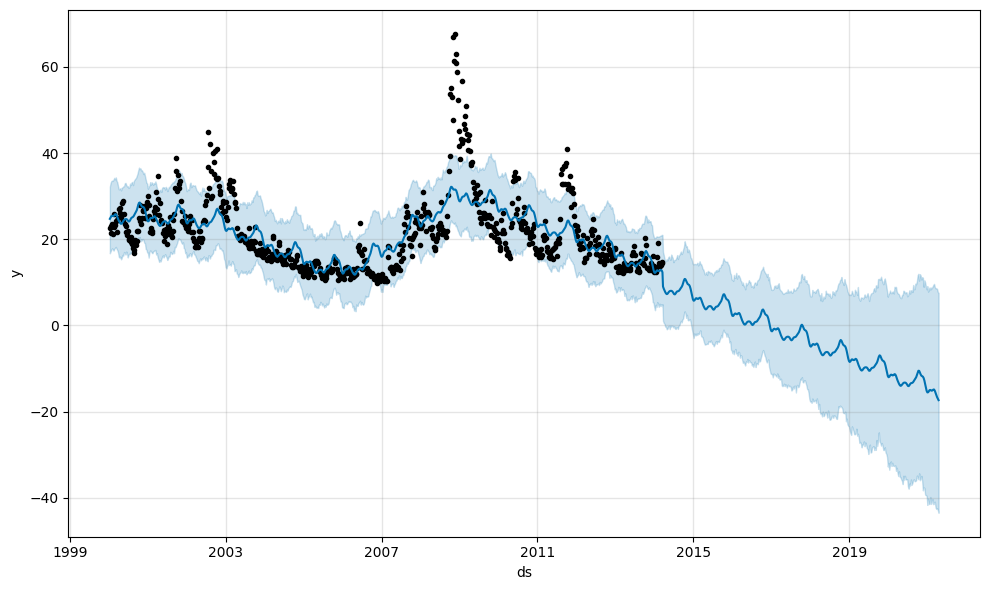

In [62]:
result = pd.concat([time_series_prophet.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

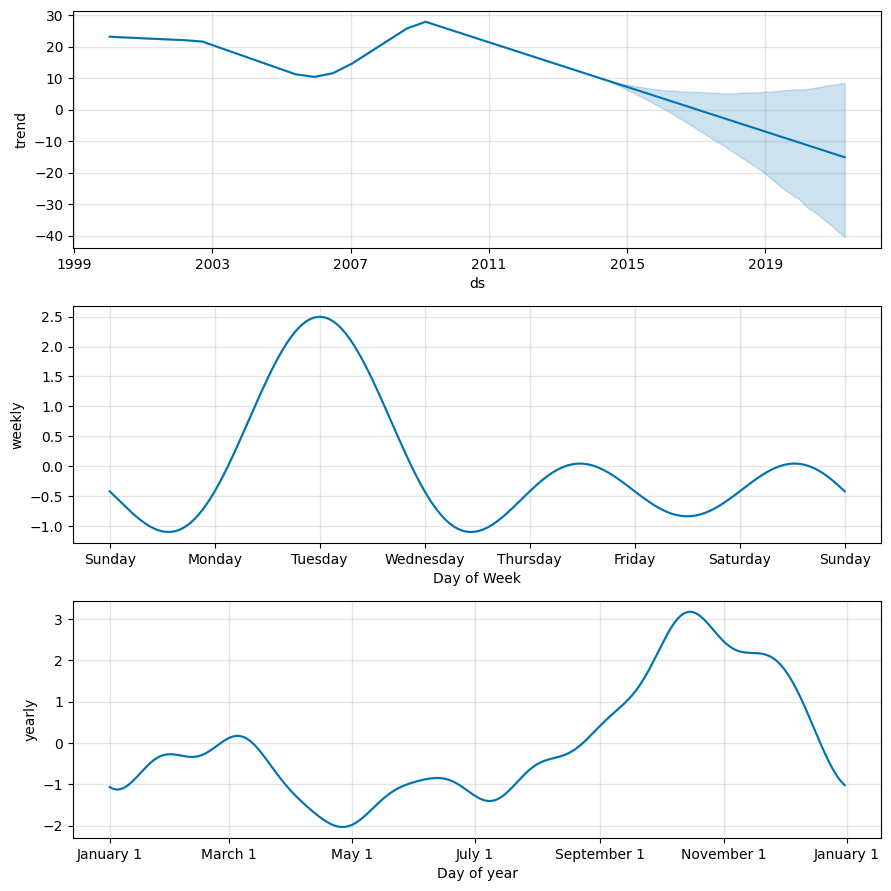

In [63]:
comp = m.plot_components(forecast)


In [64]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [65]:
result[result["error"].abs() > 1.5*result["uncertainty"]]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2008-10-28,66.96,31.804615,23.865490,39.383303,35.155385,15.517814
2008-11-11,61.44,31.485540,23.524443,39.260043,29.954460,15.735600
2008-11-18,67.64,31.538302,23.881311,39.502517,36.101698,15.621207
2008-11-25,60.90,31.502212,23.014853,39.437925,29.397788,16.423072
2008-12-02,62.98,31.222270,23.137265,39.388151,31.757730,16.250886
2008-12-09,58.91,30.676628,22.472489,38.326004,28.233372,15.853515
2009-01-20,56.65,29.504627,21.784906,37.213802,27.145373,15.428896


In [66]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') #Alternate way

In [67]:
result.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2000-01-11,22.50,24.720542,16.730671,32.181805,-2.220542,15.451134,No
2000-01-18,21.50,25.052122,17.188856,33.036622,-3.552122,15.847766,No
2000-01-25,23.02,25.348054,17.596991,33.494046,-2.328054,15.897055,No
2000-02-01,23.45,25.434255,17.891295,33.598302,-1.984255,15.707008,No
2000-02-08,21.25,25.373677,17.674513,33.520859,-4.123677,15.846345,No


In [68]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Market Anomaly')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

In [69]:
time_series_data = financial_market_data[["Data", "MXEU"]]

In [70]:
time_series_data.head()

,Data,MXEU
0,1/11/2000,127.75
1,1/18/2000,129.50
2,1/25/2000,126.48
3,2/1/2000,129.19
4,2/8/2000,134.67


In [71]:
time_series_prophet = time_series_data.reset_index()[["Data", "MXEU"]].rename(columns={"Data":"ds", "MXEU":"y"})

In [72]:
time_series_prophet["ds"] = pd.to_datetime(time_series_prophet["ds"])

In [73]:
time_series_prophet.head()

,ds,y
0,2000-01-11,127.75
1,2000-01-18,129.50
2,2000-01-25,126.48
3,2000-02-01,129.19
4,2000-02-08,134.67


In [74]:
time_series_prophet.tail()

,ds,y
1106,2021-03-23,140.32
1107,2021-03-30,142.76
1108,2021-04-06,144.13
1109,2021-04-13,144.23
1110,2021-04-20,146.39


In [75]:
1111/3

370.3333333333333

In [76]:
1111-370

741

In [77]:
time_series_prophet.iloc[[740]]

,ds,y
740,2014-03-18,111.53


In [78]:
train = time_series_prophet[(time_series_prophet['ds'] >= '2000-01-11') & (time_series_prophet['ds'] <= '2014-03-18')]
test = time_series_prophet[(time_series_prophet['ds'] > '2014-03-18')]

In [79]:
train.head(), train.tail(), test.head(), test.tail()

(          ds       y
 0 2000-01-11  127.75
 1 2000-01-18  129.50
 2 2000-01-25  126.48
 3 2000-02-01  129.19
 4 2000-02-08  134.67,
             ds       y
 736 2014-02-18  114.11
 737 2014-02-25  115.34
 738 2014-03-04  114.81
 739 2014-03-11  112.82
 740 2014-03-18  111.53,
             ds       y
 741 2014-03-25  111.87
 742 2014-04-01  114.47
 743 2014-04-08  113.79
 744 2014-04-15  111.51
 745 2014-04-22  114.92,
              ds       y
 1106 2021-03-23  140.32
 1107 2021-03-30  142.76
 1108 2021-04-06  144.13
 1109 2021-04-13  144.23
 1110 2021-04-20  146.39)

In [80]:
m = Prophet(changepoint_range=0.95, weekly_seasonality=True)
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2fge9sny/b1se6j7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2fge9sny/hm1px_wa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55808', 'data', 'file=/tmp/tmp2fge9sny/b1se6j7a.json', 'init=/tmp/tmp2fge9sny/hm1px_wa.json', 'output', 'file=/tmp/tmp2fge9sny/prophet_modelgy0gvue5/prophet_model-20250119101326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:13:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:13:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [81]:
future = m.make_future_dataframe(periods=370, freq='W')

In [82]:
future.head()

,ds
0,2000-01-11
1,2000-01-18
2,2000-01-25
3,2000-02-01
4,2000-02-08


In [83]:
future.tail()

,ds
1106,2021-03-21
1107,2021-03-28
1108,2021-04-04
1109,2021-04-11
1110,2021-04-18


In [84]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1106,2021-03-21,186.448107,3.680157,383.802861
1107,2021-03-28,187.232490,3.351959,383.493445
1108,2021-04-04,187.822109,2.360173,387.097504
1109,2021-04-11,188.276094,3.989084,388.685170
1110,2021-04-18,188.817403,1.042886,393.023251


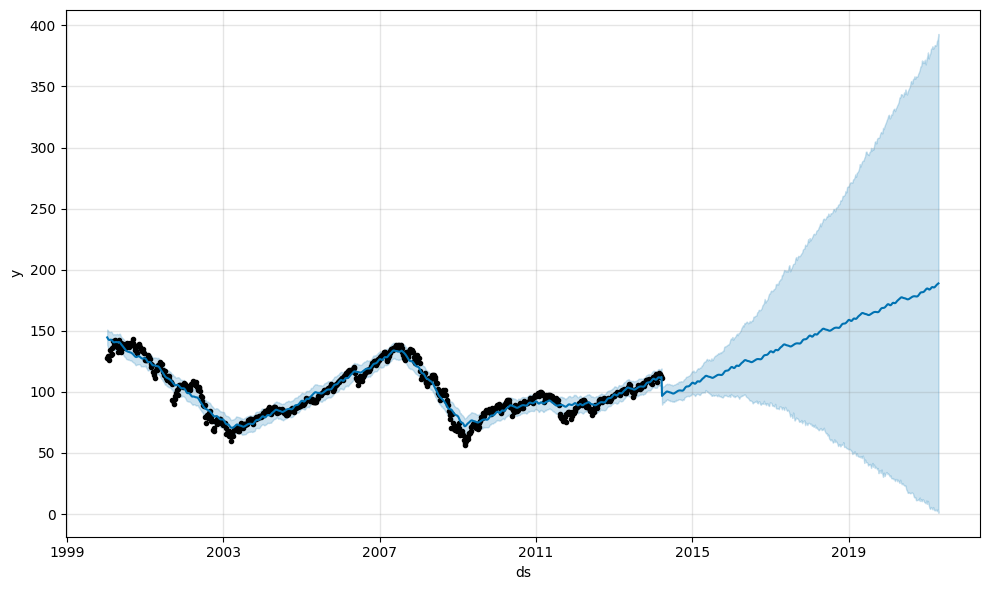

In [85]:
result = pd.concat([time_series_prophet.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

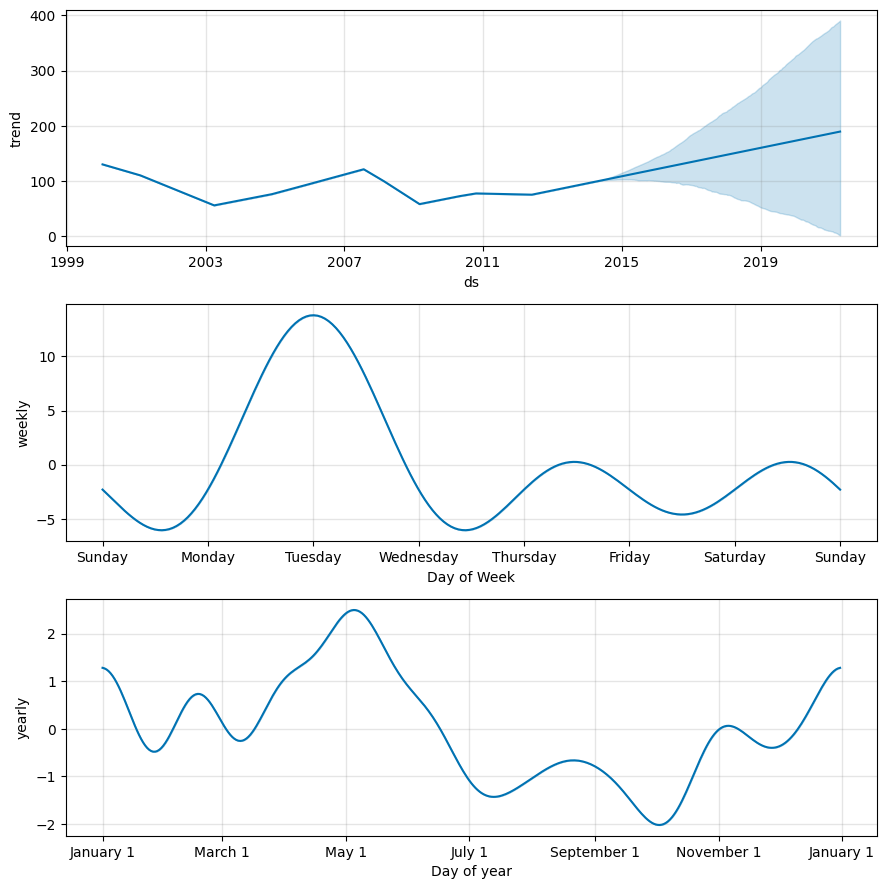

In [86]:
comp = m.plot_components(forecast)


In [87]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [88]:
result[result["error"].abs() > 1.5*result["uncertainty"]]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,


In [89]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') #Alternate way

In [90]:
result.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2000-01-11,127.75,144.610307,138.411234,151.029943,-16.860307,12.618709,No
2000-01-18,129.50,143.533831,136.346622,150.279562,-14.033831,13.932940,No
2000-01-25,126.48,142.702511,135.996797,149.379711,-16.222511,13.382915,No
2000-02-01,129.19,142.462718,135.409358,148.922366,-13.272718,13.513008,No
2000-02-08,134.67,142.667677,135.705355,149.062994,-7.997677,13.357639,No


In [91]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Market Anomaly')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

In [94]:
!pip install scipy==1.14.0
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 10.1 MB/s eta 0:00:00
